In [248]:
import pandas as pd

frame = pd.read_csv('titanic.csv')
frame.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [249]:
frame.where(pd.notnull(frame['boat']))['survived'].value_counts()

1.0    477
0.0      9
Name: survived, dtype: int64

In [250]:
frame['survived'].value_counts(normalize=True)

0    0.618029
1    0.381971
Name: survived, dtype: float64

In [251]:
frame.dropna(subset=['pclass','sex','embarked'], axis=0, inplace=True)
#frame.replace(to_replace=pd.notnull(frame['boat']), value=999, inplace=True)
frame['boat'].fillna(value=-999,inplace=True)

frame.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,-999,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,-999,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,-999,NaN,"Montreal, PQ / Chesterville, ON"


In [252]:
frame['boat'].value_counts()

-999       823
13          39
C           38
15          37
14          33
4           31
10          29
5           27
3           26
11          25
9           25
7           23
16          23
8           23
D           20
12          19
6           18
2           13
A           11
B            9
1            5
13 15        2
5 7          2
C D          2
13 15 B      1
8 10         1
5 9          1
15 16        1
Name: boat, dtype: int64

In [253]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [254]:
from sklearn.ensemble import RandomForestClassifier

In [255]:
clf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1, max_depth=5, bootstrap=True)

In [256]:
from sklearn.base import TransformerMixin
import numpy as np

class DataFrameImputer(TransformerMixin):

    def __init__(self, replace_value):
        self.replace_value = replace_value
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return np.nan_to_num(X, copy=True)

class DataTypeConverter(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.astype(self.dtype)

In [281]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer
cat_pipe = Pipeline([
    ('selector', DataFrameSelector(['Pclass','Sex','Embarked'])),
    ('encoder', OneHotEncoder(sparse=False))
])

#boat_pipe = Pipeline([
#    ('selector', DataFrameSelector(['Boat'])),
#    ('dtype', DataTypeConverter(np.str)),
#    ('encoder', OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore'))
#])

num_pipe = Pipeline([
    ('selector', DataFrameSelector(['Age','SibSp','Parch','Fare'])),
    ('imputer', SimpleImputer(strategy='median'))
])

In [282]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipe),
    ('cat_pipeline', cat_pipe),
    #('boat_pipeline', boat_pipe)
])

In [264]:
frame.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,-999,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,-999,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,-999,NaN,"Montreal, PQ / Chesterville, ON"


In [265]:
pd.unique(frame['boat'])

array(['2', '11', -999, '3', '10', 'D', '4', '9', '6', 'B', '8', 'A', '5',
       '7', 'C', '14', '5 9', '13', '1', '15', '5 7', '8 10', '12', '16',
       '13 15 B', 'C D', '15 16', '13 15'], dtype=object)

In [266]:
y = frame['survived']

titanic_x = full_pipeline.fit_transform(frame.drop('survived', axis=1))
feature_names = ['Age','SibSp','Parch','Fare','first_class','second_class','third_class',
                 'female','male','Southhampton','Cherbourg','Queenstown']
print(len(feature_names),len(titanic_x[0]))
titanic_df = pd.DataFrame(titanic_x, columns=feature_names)
titanic_df.head()

12 12


,Age,SibSp,Parch,Fare,first_class,second_class,third_class,female,male,Southhampton,Cherbourg,Queenstown
0,29.0000,0.0,0.0,211.3375,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.9167,1.0,2.0,151.5500,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,2.0000,1.0,2.0,151.5500,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,30.0000,1.0,2.0,151.5500,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,25.0000,1.0,2.0,151.5500,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [267]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(titanic_x, y, test_size=0.2, shuffle=False)
x_train[0]

array([ 29.    ,   0.    ,   0.    , 211.3375,   1.    ,   0.    ,
         0.    ,   1.    ,   0.    ,   0.    ,   0.    ,   1.    ])

In [236]:
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [237]:
clf.oob_score_

0.9741626794258373

In [238]:
from sklearn.metrics import accuracy_score

predictions = clf.predict(x_test)

accuracy_score(y_test,predictions)

0.9732824427480916

In [268]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(clf, {'n_estimators':[100, 150, 200], 'max_depth':[3,5,8]}, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)

C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=True, random_state=None,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth

In [269]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [270]:
predictions = grid_search.best_estimator_.predict(x_test)
accuracy_score(y_test,predictions)

0.7938931297709924

In [389]:

#feature_names = ['age','sibsp','parch','fare',
#                 'female','male']
val = 0
for name, score in zip(feature_names,grid_search.best_estimator_.feature_importances_):
    val += score
    print(name,score)
val

age 0.15910886144853537
sibsp 0.03731232342258544
parch 0.04117758907440155
fare 0.17659873532559006
first_class 0.03547226479457975
second_class 0.019733943124781415
third_class 0.052164973634713466
female 0.22447218616932843
male 0.22226115475735791
Southhampton 0.014407932266496094
Cherbourg 0.0057033063379185
Queenstown 0.011586729643712247


1.0000000000000002

NameError: name 'plt' is not defined

([<matplotlib.patches.Wedge at 0x144b95ad780>,
 [Text(1.0971101437489834, 0.07968269876883441, 'age'),
  Text(1.0844267400105918, 0.1844414420622458, 'sibsp'),
  Text(1.0720195842883071, 0.24652385463140378, 'parch'),
  Text(1.0193493086995817, 0.4134331709644077, 'fare'),
  Text(0.9280420189794714, 0.5905404397740316, 'first_class'),
  Text(0.8838720817121307, 0.654805423900768, 'second_class'),
  Text(0.8236313550262176, 0.7291305719949458, 'third_class'),
  Text(0.4774585604208634, 0.990975944753876, 'female'),
  Text(-0.19038216884924952, 1.0833995706959902, 'male'),
  Text(-0.5101552778475592, 0.9745468652067379, 'Southhampton'),
  Text(-0.5232892613455715, 0.9675579305449397, 'Cherbourg'),
  Text(-0.5320534131490092, 0.9627664127692085, 'Queenstown'),
  Text(-0.8846416632998961, -0.6537653459414879, '2'),
  Text(0.762477651568304, -0.7928605368278105, '11'),
  Text(0.783417731514471, -0.7721765717429664, '-999'),
  Text(0.8098667599034265, -0.7443895695155367, '3'),
  Text(0.8262

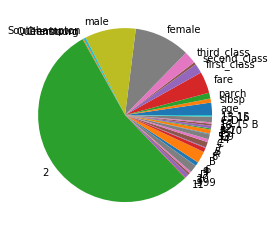

In [217]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.pie(grid_search.best_estimator_.feature_importances_,labels=feature_names)

<BarContainer object of 40 artists>

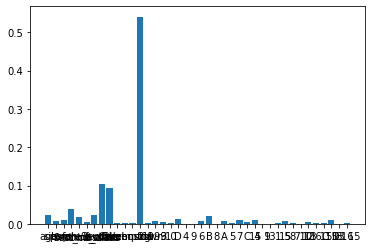

In [220]:
plt.bar(np.array(feature_names).astype(np.str), grid_search.best_estimator_.feature_importances_)

In [391]:
frame['survived'].value_counts()

0    809
1    498
Name: survived, dtype: int64

In [406]:

#frame['survived'].where(frame['sex']=='female').value_counts()


0        NaN
1       male
2        NaN
3        NaN
4        NaN
5       male
6        NaN
7        NaN
8        NaN
9        NaN
10       NaN
11       NaN
12       NaN
13       NaN
14      male
15       NaN
16       NaN
17       NaN
18       NaN
19       NaN
20      male
21       NaN
22      male
23       NaN
24       NaN
25       NaN
26      male
27       NaN
28       NaN
29      male
        ... 
1279     NaN
1280     NaN
1281     NaN
1282     NaN
1283     NaN
1284     NaN
1285     NaN
1286     NaN
1287     NaN
1288     NaN
1289     NaN
1290     NaN
1291     NaN
1292     NaN
1293     NaN
1294     NaN
1295     NaN
1296     NaN
1297     NaN
1298     NaN
1299     NaN
1300     NaN
1301     NaN
1302     NaN
1303     NaN
1304     NaN
1305     NaN
1306     NaN
1307     NaN
1308     NaN
Name: sex, Length: 1307, dtype: object

In [276]:
# Now time to create predictions to submit
frame = pd.read_csv('test.csv')
frame.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [283]:
titanic_val = full_pipeline.fit_transform(frame)

In [284]:
predictions = grid_search.best_estimator_.predict(titanic_val)

In [286]:
print('PassengerId,Survived')
[print('{},{}'.format(idnum,pred)) for idnum,pred in zip(frame['PassengerId'],predictions)]

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,0
899,0
900,1
901,0
902,0
903,0
904,1
905,0
906,1
907,1
908,0
909,0
910,0
911,1
912,0
913,1
914,1
915,1
916,1
917,0
918,1
919,0
920,0
921,0
922,0
923,0
924,1
925,0
926,1
927,0
928,0
929,0
930,0
931,1
932,1
933,0
934,0
935,1
936,1
937,0
938,0
939,0
940,1
941,1
942,0
943,0
944,1
945,1
946,0
947,0
948,0
949,0
950,0
951,1
952,0
953,0
954,0
955,1
956,1
957,1
958,0
959,0
960,0
961,1
962,1
963,0
964,0
965,0
966,1
967,0
968,0
969,1
970,0
971,1
972,0
973,0
974,0
975,0
976,0
977,0
978,1
979,1
980,1
981,1
982,1
983,0
984,1
985,0
986,0
987,0
988,1
989,0
990,0
991,0
992,1
993,0
994,0
995,0
996,1
997,0
998,0
999,0
1000,0
1001,0
1002,0
1003,1
1004,0
1005,0
1006,0
1007,0
1008,0
1009,1
1010,0
1011,1
1012,1
1013,0
1014,1
1015,0
1016,0
1017,1
1018,0
1019,1
1020,0
1021,0
1022,0
1023,0
1024,0
1025,0
1026,0
1027,0
1028,0
1029,0
1030,0
1031,0
1032,0
1033,1
1034,0
1035,0
1036,0
1037,0
1038,0
1039,0
1040,0
1041,0
1042,1
1043,0
1044,0
1045,0
1046,0
10

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,